In [6]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize, LabelEncoder
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet152, InceptionV3, DenseNet121, MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import cv2
import time

sns.set_style('whitegrid')

In [7]:
from tensorflow.keras.applications.imagenet_utils import preprocess_input

In [8]:
import sys
import pandas.core.indexes as indexes
sys.modules['pandas.indexes'] = indexes
sys.modules['pandas.indexes.base'] = indexes.base
sys.modules['pandas.indexes.range'] = indexes.range

data_path = '/kaggle/input/wm811k-wafer-map/LSWMD.pkl'

with open(data_path, 'rb') as f:
    df = pickle.load(f, encoding='latin1')

print(f"Dataset loaded: {len(df):,} samples")
print(f"Columns: {list(df.columns)}")

Dataset loaded: 811,457 samples
Columns: ['waferMap', 'dieSize', 'lotName', 'waferIndex', 'trianTestLabel', 'failureType']


In [9]:
df_clean = df[(df['waferMap'].notna()) & 
              (df['failureType'].notna()) & 
              (df['failureType'] != 'none')]
labels_raw = []
for ft in df_clean['failureType']:
    if isinstance(ft, np.ndarray):
        labels_raw.append(str(ft[0]) if len(ft) > 0 else 'unknown')
    else:
        labels_raw.append(str(ft))

df_clean['failureType_str'] = labels_raw

print(f"Clean samples: {len(df_clean):,}")
print("\nClass Distribution:")
print(pd.Series(labels_raw).value_counts())

Clean samples: 25,519

Class Distribution:
['Edge-Ring']    9680
['Edge-Loc']     5189
['Center']       4294
['Loc']          3593
['Scratch']      1193
['Random']        866
['Donut']         555
['Near-full']     149
Name: count, dtype: int64


In [10]:
wafer_maps = list(df_clean['waferMap'])
labels = df_clean['failureType_str'].values

le = LabelEncoder()
y_encoded = le.fit_transform(labels)

X_train, X_test, y_train, y_test = train_test_split(
    wafer_maps, y_encoded,
    test_size=0.2,
    random_state=42,
    stratify=y_encoded
)

num_classes = len(le.classes_)
print(f"Training: {len(X_train):,} | Test: {len(X_test):,}")
print(f"Classes: {num_classes}")
print(f"Label mapping: {dict(enumerate(le.classes_))}")

Training: 20,415 | Test: 5,104
Classes: 8
Label mapping: {0: "['Center']", 1: "['Donut']", 2: "['Edge-Loc']", 3: "['Edge-Ring']", 4: "['Loc']", 5: "['Near-full']", 6: "['Random']", 7: "['Scratch']"}


In [11]:
from tensorflow.keras.utils import Sequence

class WaferDataGenerator(Sequence):

    def __init__(self, wafer_maps, labels, num_classes, batch_size=16, shuffle=True):
        self.wafer_maps = wafer_maps
        self.labels = np.asarray(labels).astype(int).ravel()  # ✅ force clean labels
        self.num_classes = num_classes
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indices = np.arange(len(self.wafer_maps))
        self.on_epoch_end()
    
    def __len__(self):
        return int(np.ceil(len(self.wafer_maps) / self.batch_size))
    
    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]

        X_batch = []
        for i in batch_indices:
            arr = np.array(self.wafer_maps[i], dtype=np.float32)
    
            if np.random.rand() < 0.5:
                arr = np.fliplr(arr)
            if np.random.rand() < 0.5:
                arr = np.flipud(arr)
    
            if arr.max() > 0:
                arr = arr / arr.max()
    
            arr_resized = cv2.resize(arr, (224, 224))
            arr_rgb = np.stack([arr_resized] * 3, axis=-1)
            arr_rgb = preprocess_input(arr_rgb * 255.0)
    
            X_batch.append(arr_rgb)
    
        X_batch = np.array(X_batch, dtype=np.float32)
        y_batch = np.array(self.labels[batch_indices], dtype=np.int32)
    
        return X_batch, y_batch

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

y_train = np.asarray(y_train).astype(int).ravel()
y_test  = np.asarray(y_test).astype(int).ravel()

train_gen = WaferDataGenerator(X_train, y_train, num_classes=num_classes, batch_size=16, shuffle=True)
test_gen  = WaferDataGenerator(X_test, y_test,  num_classes=num_classes, batch_size=16, shuffle=False)

print(f"Train generator: {len(train_gen)} batches")
print(f"Test generator: {len(test_gen)} batches")

Train generator: 1276 batches
Test generator: 319 batches


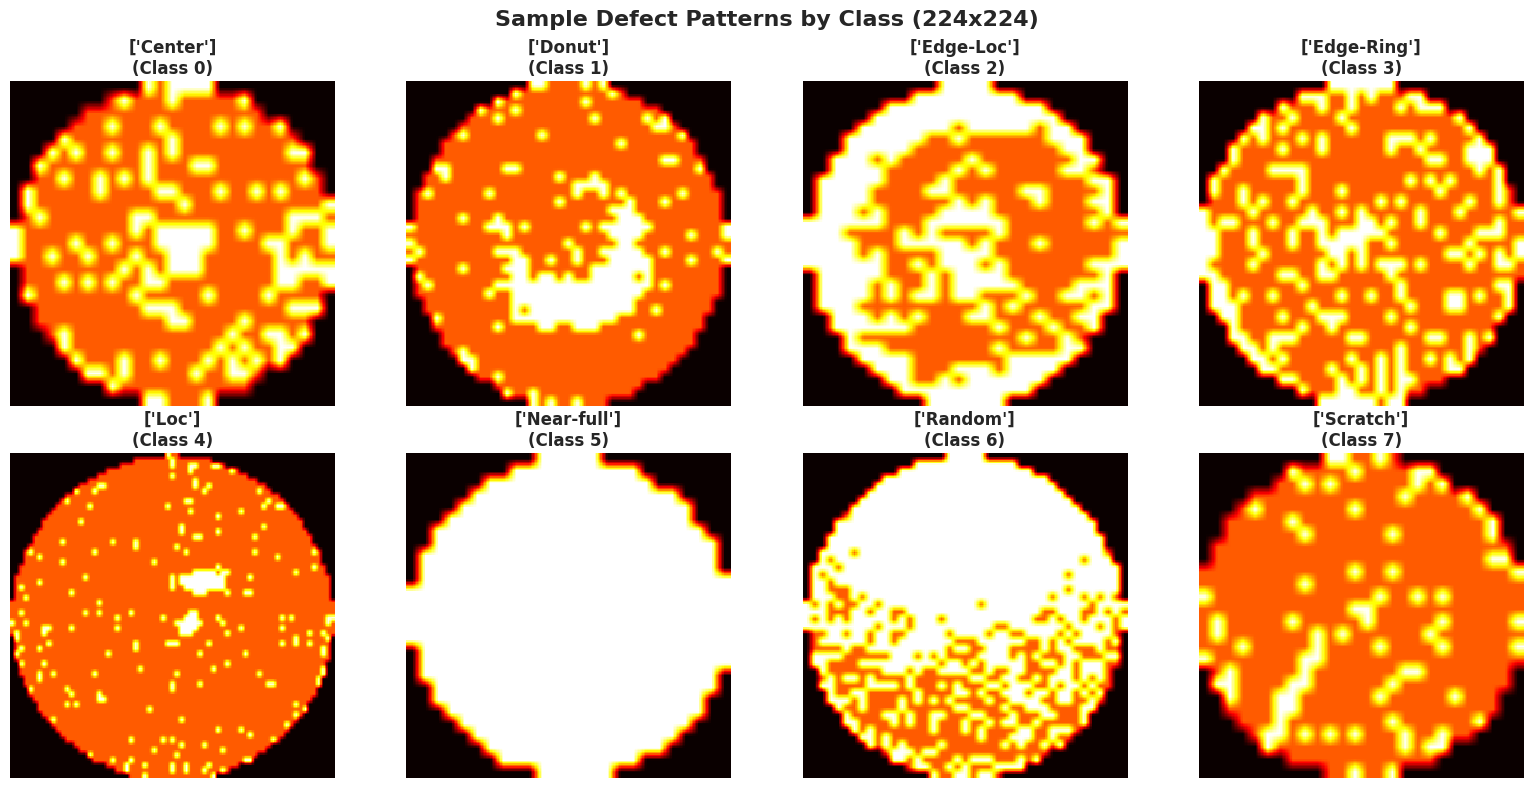

In [12]:
def preprocess_single(wafer_map):
    arr = np.array(wafer_map, dtype=np.float32)
    if arr.max() > 0:
        arr = arr / arr.max()
    arr_resized = cv2.resize(arr, (224, 224))
    return arr_resized

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.ravel()

for i, class_name in enumerate(le.classes_):
    class_idx = np.where(y_train == i)[0][0]
    sample = preprocess_single(X_train[class_idx])
    
    axes[i].imshow(sample, cmap='hot', interpolation='nearest')
    axes[i].set_title(f'{class_name}\n(Class {i})', fontsize=12, fontweight='bold')
    axes[i].axis('off')

plt.suptitle('Sample Defect Patterns by Class (224x224)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

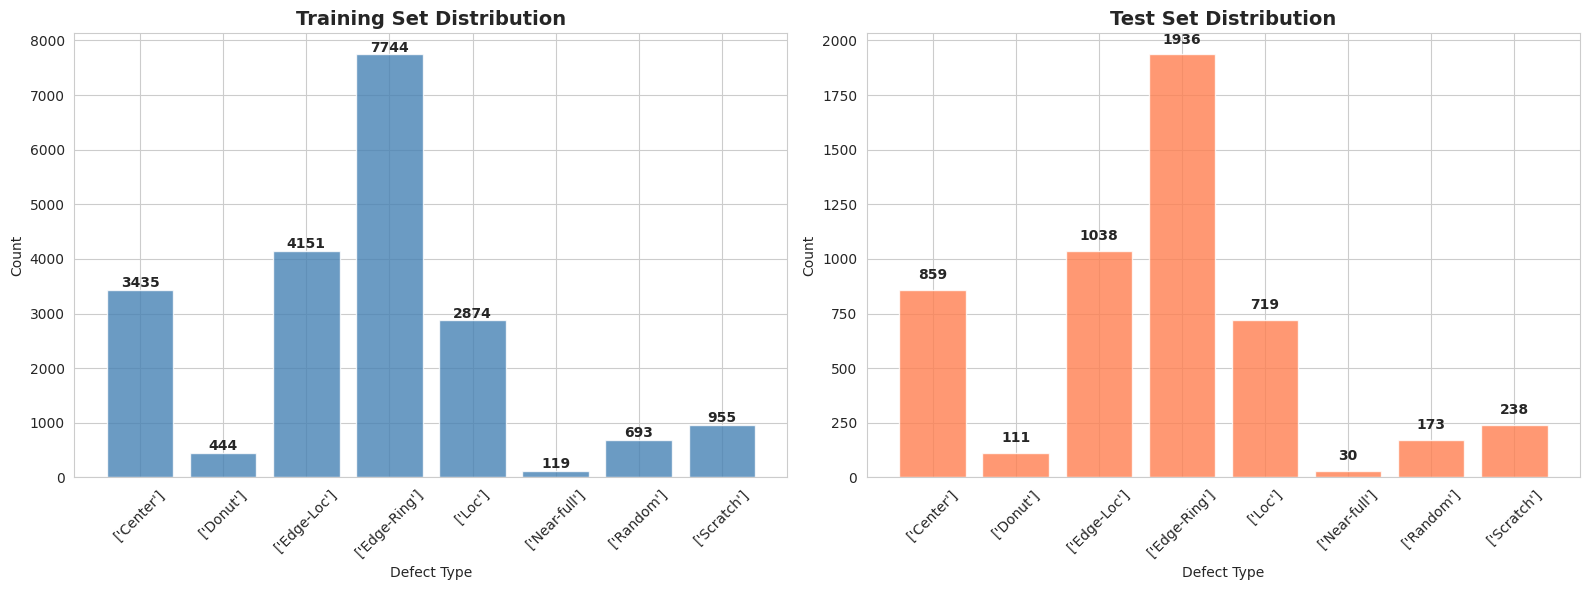

Class distribution analyzed!

Class Balance Ratio (Train): 0.015
Class Balance Ratio (Test): 0.015


In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

train_counts = pd.Series(y_train).value_counts().sort_index()
train_labels = [le.classes_[i] for i in train_counts.index]
ax1.bar(train_labels, train_counts.values, color='steelblue', alpha=0.8)
ax1.set_title('Training Set Distribution', fontsize=14, fontweight='bold')
ax1.set_xlabel('Defect Type')
ax1.set_ylabel('Count')
ax1.tick_params(axis='x', rotation=45)
for i, v in enumerate(train_counts.values):
    ax1.text(i, v + 50, str(v), ha='center', fontweight='bold')

test_counts = pd.Series(y_test).value_counts().sort_index()
test_labels = [le.classes_[i] for i in test_counts.index]
ax2.bar(test_labels, test_counts.values, color='coral', alpha=0.8)
ax2.set_title('Test Set Distribution', fontsize=14, fontweight='bold')
ax2.set_xlabel('Defect Type')
ax2.set_ylabel('Count')
ax2.tick_params(axis='x', rotation=45)
for i, v in enumerate(test_counts.values):
    ax2.text(i, v + 50, str(v), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

print("Class distribution analyzed!")
print(f"\nClass Balance Ratio (Train): {train_counts.min() / train_counts.max():.3f}")
print(f"Class Balance Ratio (Test): {test_counts.min() / test_counts.max():.3f}")

PCA explained variance: 61.36%


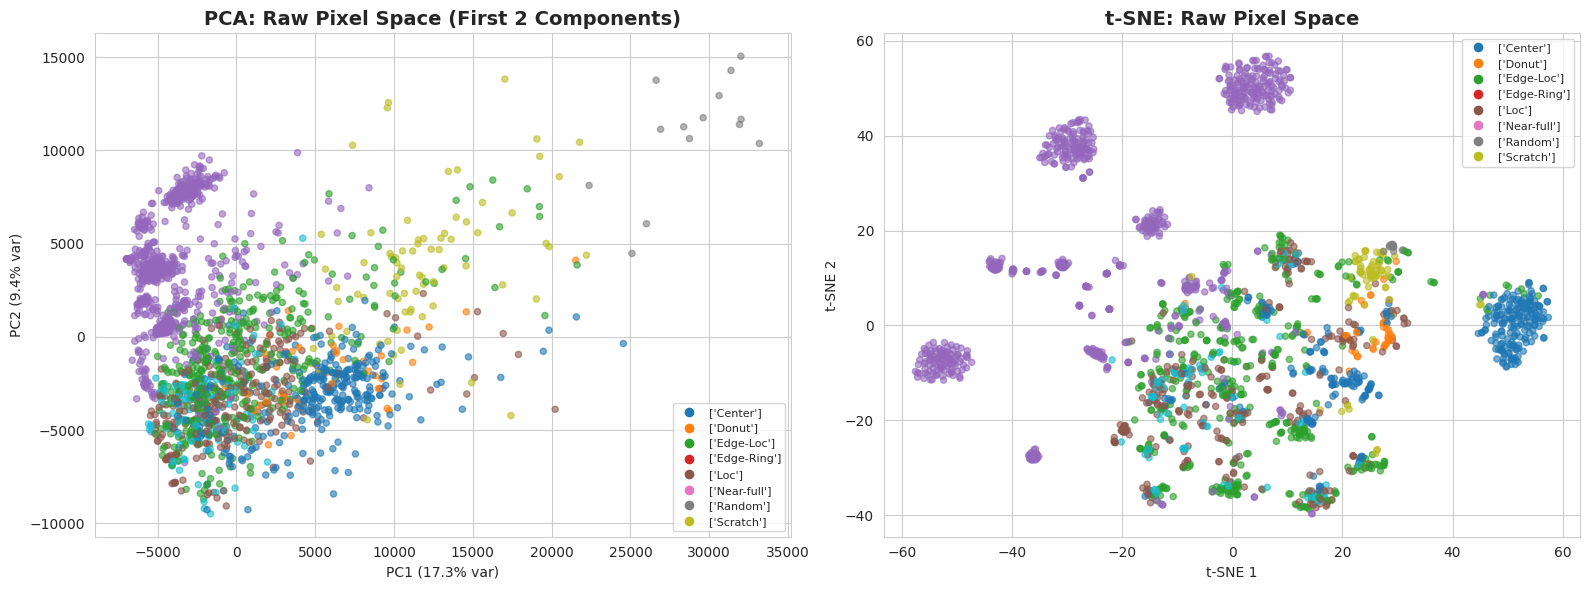

In [14]:
X_subset_flat = []
for i in range(min(2000, len(X_train))):
    arr = np.array(X_train[i], dtype=np.float32)
    if arr.max() > 0:
        arr = arr / arr.max()
    arr_resized = cv2.resize(arr, (224, 224))
    arr_rgb = np.stack([arr_resized] * 3, axis=-1)
    arr_rgb = preprocess_input(arr_rgb * 255.0)

    X_subset_flat.append(arr_rgb.flatten())

X_subset_flat = np.array(X_subset_flat)
y_train_subset = y_train[:len(X_subset_flat)]

pca = PCA(n_components=50, random_state=42)
X_pca = pca.fit_transform(X_subset_flat)
print(f"PCA explained variance: {pca.explained_variance_ratio_.sum():.2%}")

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_pca)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

scatter1 = ax1.scatter(X_pca[:, 0], X_pca[:, 1], 
                       c=y_train_subset, cmap='tab10', 
                       alpha=0.6, s=20)
ax1.set_title('PCA: Raw Pixel Space (First 2 Components)', 
              fontsize=14, fontweight='bold')
ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} var)')
ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} var)')

legend_elements_1 = [plt.Line2D([0], [0], marker='o', color='w', 
                                markerfacecolor=plt.cm.tab10(i/num_classes), 
                                markersize=8, label=le.classes_[i]) 
                     for i in range(num_classes)]
ax1.legend(handles=legend_elements_1, loc='best', fontsize=8)

scatter2 = ax2.scatter(X_tsne[:, 0], X_tsne[:, 1], 
                       c=y_train_subset, cmap='tab10', 
                       alpha=0.6, s=20)
ax2.set_title('t-SNE: Raw Pixel Space', fontsize=14, fontweight='bold')
ax2.set_xlabel('t-SNE 1')
ax2.set_ylabel('t-SNE 2')

legend_elements_2 = [plt.Line2D([0], [0], marker='o', color='w', 
                                markerfacecolor=plt.cm.tab10(i/num_classes), 
                                markersize=8, label=le.classes_[i]) 
                     for i in range(num_classes)]
ax2.legend(handles=legend_elements_2, loc='best', fontsize=8)

plt.tight_layout()
plt.show()

**section 3 hai**

In [15]:
def build_custom_cnn(input_shape=(224, 224, 3), num_classes=8):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),
        
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.GlobalAveragePooling2D(),
        
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

custom_cnn = build_custom_cnn(num_classes=num_classes)
custom_cnn.summary()

I0000 00:00:1766711644.917937      98 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1766711644.918655      98 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,444,136 (5.51 MB)

 Trainable params: 1,440,680 (5.50 MB)

 Non-trainable params: 3,456 (13.50 KB)

In [16]:
def build_resnet152(input_shape=(224, 224, 3), num_classes=8):
    base_model = ResNet152(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )
    
    for layer in base_model.layers:
        layer.trainable = True
    
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-5),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

resnet_model = build_resnet152(num_classes=num_classes)
print(f"ResNet152 built")
print(f"Total params: {resnet_model.count_params():,}")
print(f"Trainable params: {sum([tf.size(w).numpy() for w in resnet_model.trainable_weights]):,}")

234698864/234698864 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
ResNet152 built
Total params: 59,426,184
Trainable params: 59,273,736


In [17]:
def build_inceptionv3(input_shape=(224, 224, 3), num_classes=8):
    base_model = InceptionV3(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )
    
    for layer in base_model.layers:
        layer.trainable = True
    
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-5),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model
inception_model = build_inceptionv3(num_classes=num_classes)
print(f"InceptionV3 built!")
print(f"Total params: {inception_model.count_params():,}")
print(f"Trainable params: {sum([tf.size(w).numpy() for w in inception_model.trainable_weights]):,}")

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
InceptionV3 built!
Total params: 22,858,024
Trainable params: 22,822,568


In [18]:
def build_densenet121(input_shape=(224, 224, 3), num_classes=8):
    base_model = DenseNet121(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )
    
    for layer in base_model.layers:
        layer.trainable = True
    
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-5),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

densenet_model = build_densenet121(num_classes=num_classes)
print(f"DenseNet121 built")
print(f"Total params: {densenet_model.count_params():,}")
print(f"Trainable params: {sum([tf.size(w).numpy() for w in densenet_model.trainable_weights]):,}")

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
DenseNet121 built
Total params: 7,568,456
Trainable params: 7,483,784


In [19]:
def build_mobilenetv2(input_shape=(224, 224, 3), num_classes=8):
    base_model = MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )
    
    for layer in base_model.layers[:-30]:
        layer.trainable = False
    
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-5),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

mobilenet_model = build_mobilenetv2(num_classes=num_classes)
print(f"MobileNetV2 built")
print(f"Total params: {mobilenet_model.count_params():,}")
print(f"Trainable params: {sum([tf.size(w).numpy() for w in mobilenet_model.trainable_weights]):,}")

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
MobileNetV2 built
Total params: 2,920,008
Trainable params: 2,187,400


**imp block ---- rishi look into this --- this is like the training universal block, have included callbacks**

In [20]:
def train_model_gen(model, model_name, train_gen, test_gen, epochs=15):
    print(f"Training {model_name}")
    
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1)
    ]
    
    start_time = time.time()
    
    history = model.fit(
        train_gen,
        validation_data=test_gen,
        epochs=epochs,
        callbacks=callbacks,
        verbose=1
    )
    
    train_time = time.time() - start_time
    
    test_loss, test_acc = model.evaluate(test_gen, verbose=0)
    
    print(f"\n{model_name} Complete")
    print(f"Time: {train_time/60:.2f} minutes")
    print(f"Test Accuracy: {test_acc*100:.2f}%")
    
    return history, train_time, test_acc

In [21]:
def clear_session_memory():
    keras.backend.clear_session()
    import gc
    gc.collect()
    print("Memory cleared")

print("Memory management ready!")

Memory management ready!


Training Custom CNN
Epoch 1/15


I0000 00:00:1766711664.993054     160 service.cc:148] XLA service 0x7dec5000a030 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1766711664.994399     160 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1766711664.994421     160 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1766711665.993035     160 cuda_dnn.cc:529] Loaded cuDNN version 90300


   1/1276 ━━━━━━━━━━━━━━━━━━━━ 7:25:20 21s/step - accuracy: 0.0000e+00 - loss: 4.2188

I0000 00:00:1766711679.510698     160 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1276/1276 ━━━━━━━━━━━━━━━━━━━━ 139s 93ms/step - accuracy: 0.5695 - loss: 1.3726 - val_accuracy: 0.5425 - val_loss: 2.3493 - learning_rate: 0.0010
Epoch 2/15
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 108s 84ms/step - accuracy: 0.7348 - loss: 0.7104 - val_accuracy: 0.7478 - val_loss: 0.6524 - learning_rate: 0.0010
Epoch 3/15
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 108s 84ms/step - accuracy: 0.7841 - loss: 0.5846 - val_accuracy: 0.8274 - val_loss: 0.5038 - learning_rate: 0.0010
Epoch 4/15
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 108s 84ms/step - accuracy: 0.8146 - loss: 0.5081 - val_accuracy: 0.5631 - val_loss: 1.4408 - learning_rate: 0.0010
Epoch 5/15
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 108s 84ms/step - accuracy: 0.8400 - loss: 0.4373 - val_accuracy: 0.7665 - val_loss: 0.7384 - learning_rate: 0.0010
Epoch 6/15
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 107s 84ms/step - accuracy: 0.8509 - loss: 0.4022 - val_accuracy: 0.8507 - val_loss: 0.4080 - learning_rate: 0.0010
Epoch 7/15
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 107s 84ms/step - accuracy: 

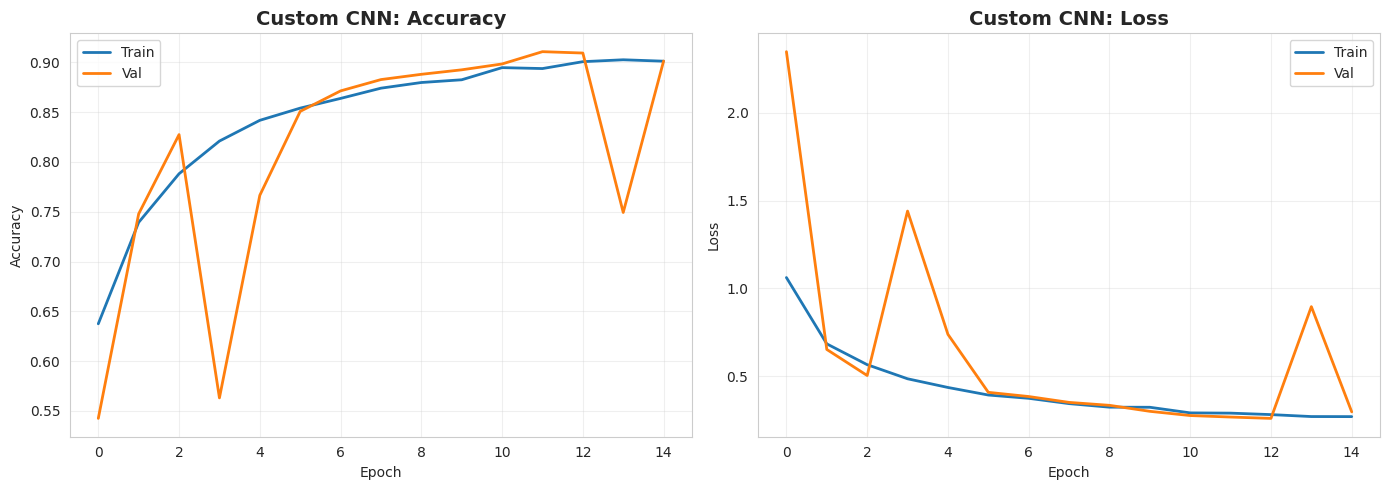

Custom CNN training complete


In [22]:
keras.backend.clear_session()
import gc
gc.collect()

model_custom = build_custom_cnn(num_classes=num_classes)

history_custom, time_custom, acc_custom = train_model_gen(
    model=model_custom,
    model_name="Custom CNN",
    train_gen=train_gen,
    test_gen=test_gen,
    epochs=15
)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(history_custom.history['accuracy'], label='Train', linewidth=2)
ax1.plot(history_custom.history['val_accuracy'], label='Val', linewidth=2)
ax1.set_title('Custom CNN: Accuracy', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(history_custom.history['loss'], label='Train', linewidth=2)
ax2.plot(history_custom.history['val_loss'], label='Val', linewidth=2)
ax2.set_title('Custom CNN: Loss', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Custom CNN training complete")

Epoch 1/5
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 229s 159ms/step - accuracy: 0.7135 - loss: 0.8367 - val_accuracy: 0.8109 - val_loss: 0.4827
Epoch 2/5
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 186s 146ms/step - accuracy: 0.7961 - loss: 0.5351 - val_accuracy: 0.8221 - val_loss: 0.4513
Epoch 3/5
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 186s 146ms/step - accuracy: 0.8126 - loss: 0.4978 - val_accuracy: 0.8292 - val_loss: 0.4418
Epoch 4/5
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 186s 146ms/step - accuracy: 0.8162 - loss: 0.4903 - val_accuracy: 0.8386 - val_loss: 0.4173
Epoch 5/5
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 186s 146ms/step - accuracy: 0.8187 - loss: 0.4800 - val_accuracy: 0.8536 - val_loss: 0.3815
Training ResNet152
Epoch 1/15
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 763s 486ms/step - accuracy: 0.7201 - loss: 0.8141 - val_accuracy: 0.8870 - val_loss: 0.3058 - learning_rate: 1.0000e-05
Epoch 2/15
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 566s 444ms/step - accuracy: 0.8806 - loss: 0.3294 - val_accuracy: 0.9101 - val_loss: 0.2669 - learning_rate: 1.0

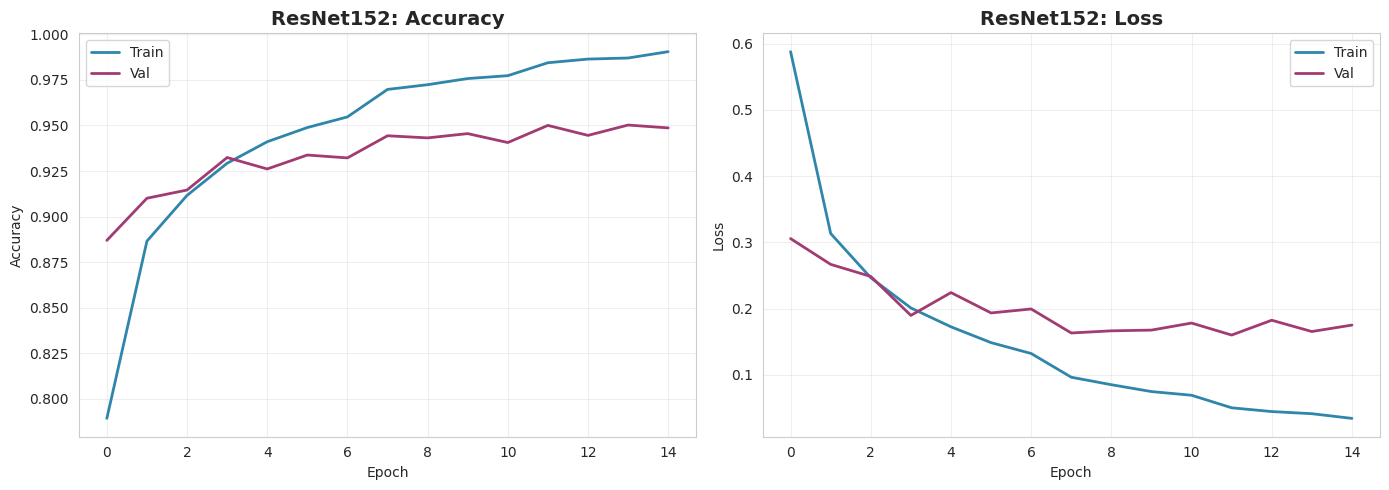

ResNet152 training complete


In [23]:
keras.backend.clear_session()
import gc
gc.collect()

model_resnet = build_resnet152(num_classes=num_classes)

model_resnet.layers[0].trainable = False
model_resnet.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_resnet.fit(train_gen, validation_data=test_gen, epochs=5)

model_resnet.layers[0].trainable = True
model_resnet.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_resnet, time_resnet, acc_resnet = train_model_gen(
    model=model_resnet,
    model_name="ResNet152",
    train_gen=train_gen,
    test_gen=test_gen,
    epochs=15
)

print(f"Final Test Accuracy: {acc_resnet*100:.2f}%")
print(f"Training Time: {time_resnet/60:.2f} minutes")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(history_resnet.history['accuracy'], label='Train', linewidth=2, color='#2E86AB')
ax1.plot(history_resnet.history['val_accuracy'], label='Val', linewidth=2, color='#A23B72')
ax1.set_title('ResNet152: Accuracy', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(history_resnet.history['loss'], label='Train', linewidth=2, color='#2E86AB')
ax2.plot(history_resnet.history['val_loss'], label='Val', linewidth=2, color='#A23B72')
ax2.set_title('ResNet152: Loss', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("ResNet152 training complete")

Epoch 1/5
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 85s 55ms/step - accuracy: 0.6360 - loss: 1.0796 - val_accuracy: 0.6495 - val_loss: 0.8959
Epoch 2/5
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 58s 45ms/step - accuracy: 0.7172 - loss: 0.7514 - val_accuracy: 0.7110 - val_loss: 0.7361
Epoch 3/5
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 58s 45ms/step - accuracy: 0.7222 - loss: 0.7361 - val_accuracy: 0.7490 - val_loss: 0.6833
Epoch 4/5
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 58s 45ms/step - accuracy: 0.7312 - loss: 0.7143 - val_accuracy: 0.7465 - val_loss: 0.6826
Epoch 5/5
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 58s 45ms/step - accuracy: 0.7307 - loss: 0.7165 - val_accuracy: 0.7649 - val_loss: 0.6140
Training InceptionV3
Epoch 1/15
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 280s 167ms/step - accuracy: 0.5685 - loss: 1.3525 - val_accuracy: 0.7426 - val_loss: 0.6893 - learning_rate: 1.0000e-05
Epoch 2/15
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 177s 139ms/step - accuracy: 0.7327 - loss: 0.7144 - val_accuracy: 0.8107 - val_loss: 0.4919 - learning_rate: 1.0000e-05


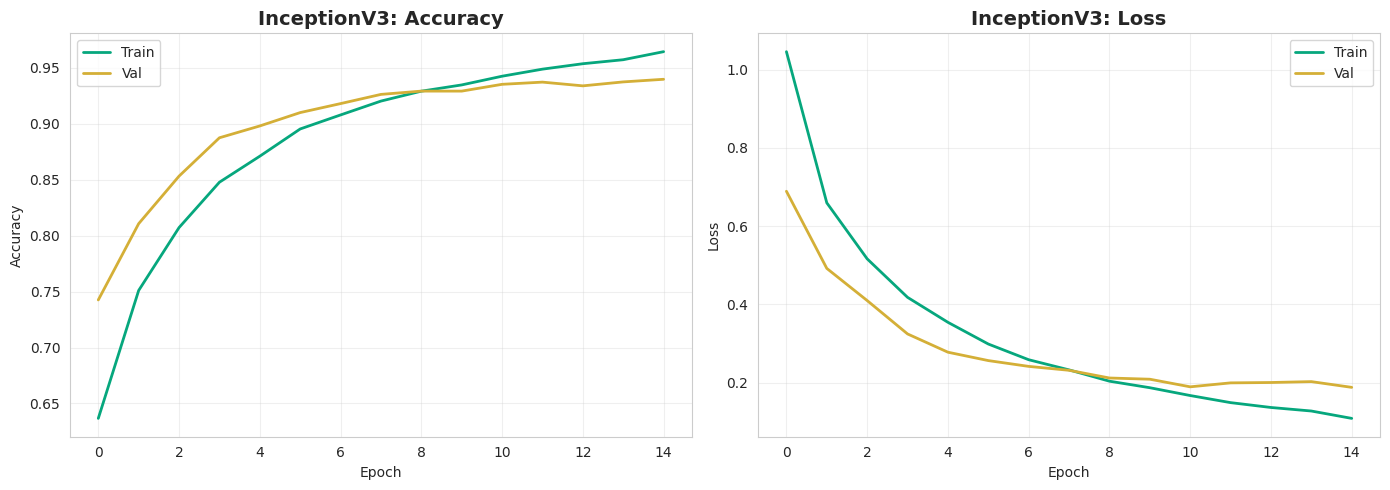

InceptionV3 training complete


In [24]:
keras.backend.clear_session()
import gc
gc.collect()

model_inception = build_inceptionv3(num_classes=num_classes)

model_inception.layers[0].trainable = False
model_inception.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_inception.fit(train_gen, validation_data=test_gen, epochs=5)

model_inception.layers[0].trainable = True
model_inception.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_inception, time_inception, acc_inception = train_model_gen(
    model=model_inception,
    model_name="InceptionV3",
    train_gen=train_gen,
    test_gen=test_gen,
    epochs=15
)


print(f"InceptionV3 Training Summary")
print(f"Final Test Accuracy: {acc_inception*100:.2f}%")
print(f"Training Time: {time_inception/60:.2f} minutes")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(history_inception.history['accuracy'], label='Train', linewidth=2, color='#06A77D')
ax1.plot(history_inception.history['val_accuracy'], label='Val', linewidth=2, color='#D4AF37')
ax1.set_title('InceptionV3: Accuracy', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(history_inception.history['loss'], label='Train', linewidth=2, color='#06A77D')
ax2.plot(history_inception.history['val_loss'], label='Val', linewidth=2, color='#D4AF37')
ax2.set_title('InceptionV3: Loss', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("InceptionV3 training complete")

Epoch 1/5
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 113s 69ms/step - accuracy: 0.6510 - loss: 0.9779 - val_accuracy: 0.7312 - val_loss: 0.7050
Epoch 2/5
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 66s 52ms/step - accuracy: 0.7287 - loss: 0.7064 - val_accuracy: 0.7598 - val_loss: 0.6143
Epoch 3/5
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 66s 52ms/step - accuracy: 0.7384 - loss: 0.6701 - val_accuracy: 0.5176 - val_loss: 1.5918
Epoch 4/5
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 66s 52ms/step - accuracy: 0.7446 - loss: 0.6598 - val_accuracy: 0.7220 - val_loss: 0.6911
Epoch 5/5
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 66s 52ms/step - accuracy: 0.7431 - loss: 0.6612 - val_accuracy: 0.6746 - val_loss: 0.8397
Training DenseNet121
Epoch 1/15
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 440s 233ms/step - accuracy: 0.5818 - loss: 1.5732 - val_accuracy: 0.7759 - val_loss: 0.6205 - learning_rate: 1.0000e-05
Epoch 2/15
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 207s 162ms/step - accuracy: 0.7591 - loss: 0.6829 - val_accuracy: 0.8229 - val_loss: 0.4917 - learning_rate: 1.0000e-05

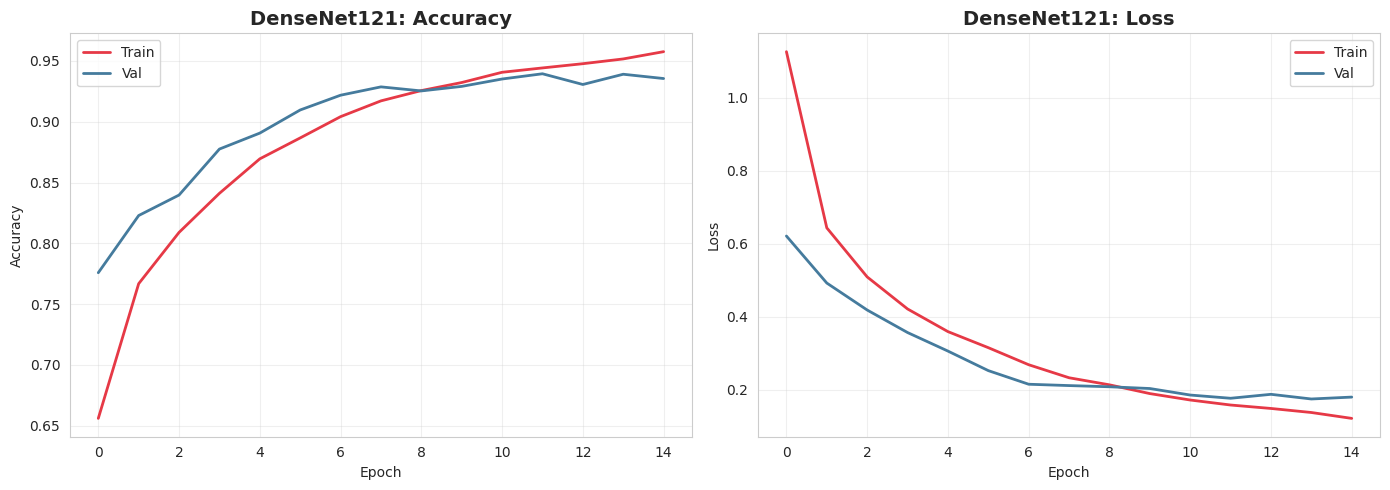

DenseNet121 training complete


In [25]:
keras.backend.clear_session()
import gc
gc.collect()

model_densenet = build_densenet121(num_classes=num_classes)

model_densenet.layers[0].trainable = False
model_densenet.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_densenet.fit(train_gen, validation_data=test_gen, epochs=5)

model_densenet.layers[0].trainable = True
model_densenet.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_densenet, time_densenet, acc_densenet = train_model_gen(
    model=model_densenet,
    model_name="DenseNet121",
    train_gen=train_gen,
    test_gen=test_gen,
    epochs=15
)

print(f"DenseNet121 Training Summary")
print(f"Final Test Accuracy: {acc_densenet*100:.2f}%")
print(f"Training Time: {time_densenet/60:.2f} minutes")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(history_densenet.history['accuracy'], label='Train', linewidth=2, color='#E63946')
ax1.plot(history_densenet.history['val_accuracy'], label='Val', linewidth=2, color='#457B9D')
ax1.set_title('DenseNet121: Accuracy', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(history_densenet.history['loss'], label='Train', linewidth=2, color='#E63946')
ax2.plot(history_densenet.history['val_loss'], label='Val', linewidth=2, color='#457B9D')
ax2.set_title('DenseNet121: Loss', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("DenseNet121 training complete")

Epoch 1/5
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 46s 29ms/step - accuracy: 0.6388 - loss: 1.0371 - val_accuracy: 0.7138 - val_loss: 0.7259
Epoch 2/5
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 29s 23ms/step - accuracy: 0.7091 - loss: 0.7507 - val_accuracy: 0.7469 - val_loss: 0.6443
Epoch 3/5
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 29s 23ms/step - accuracy: 0.7263 - loss: 0.7044 - val_accuracy: 0.7296 - val_loss: 0.6803
Epoch 4/5
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 29s 22ms/step - accuracy: 0.7324 - loss: 0.6879 - val_accuracy: 0.7398 - val_loss: 0.6566
Epoch 5/5
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 29s 23ms/step - accuracy: 0.7400 - loss: 0.6742 - val_accuracy: 0.7410 - val_loss: 0.6389
Training MobileNetV2
Epoch 1/15
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 143s 79ms/step - accuracy: 0.5642 - loss: 1.4079 - val_accuracy: 0.5347 - val_loss: 1.9751 - learning_rate: 1.0000e-05
Epoch 2/15
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 79s 62ms/step - accuracy: 0.7277 - loss: 0.7265 - val_accuracy: 0.7710 - val_loss: 0.5902 - learning_rate: 1.0000e-05
Epo

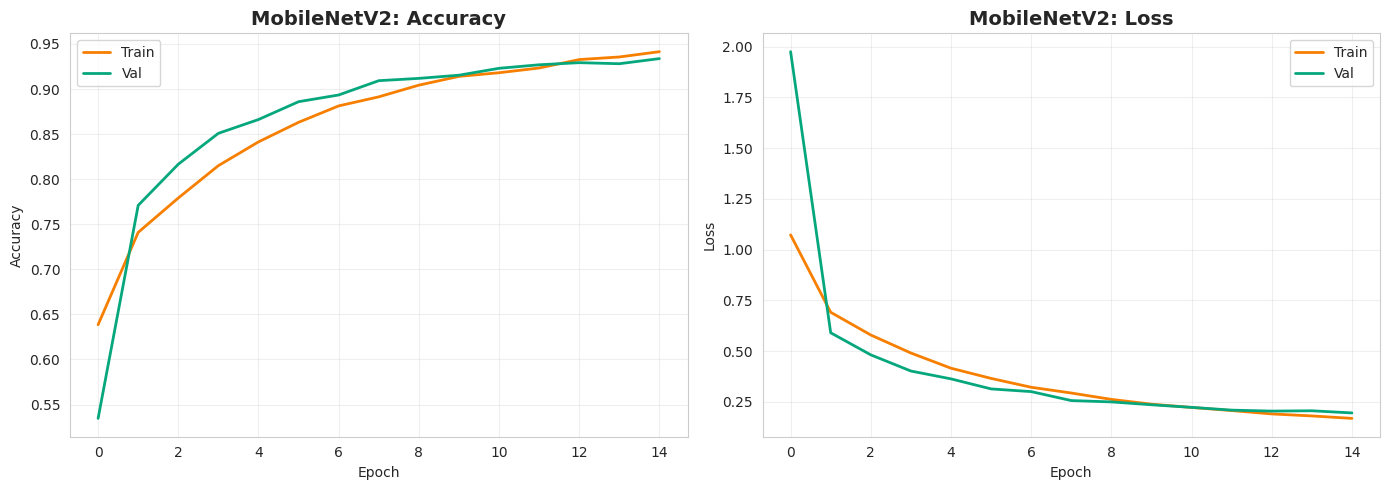

MobileNetV2 training complete


In [26]:
keras.backend.clear_session()
import gc
gc.collect()

model_mobilenet = build_mobilenetv2(num_classes=num_classes)

model_mobilenet.layers[0].trainable = False
model_mobilenet.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_mobilenet.fit(train_gen, validation_data=test_gen, epochs=5)

model_mobilenet.layers[0].trainable = True
model_mobilenet.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_mobilenet, time_mobilenet, acc_mobilenet = train_model_gen(
    model=model_mobilenet,
    model_name="MobileNetV2",
    train_gen=train_gen,
    test_gen=test_gen,
    epochs=15
)


print(f"MobileNetV2 Training Summary")
print(f"Final Test Accuracy: {acc_mobilenet*100:.2f}%")
print(f"Training Time: {time_mobilenet/60:.2f} minutes")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(history_mobilenet.history['accuracy'], label='Train', linewidth=2, color='#F77F00')
ax1.plot(history_mobilenet.history['val_accuracy'], label='Val', linewidth=2, color='#06A77D')
ax1.set_title('MobileNetV2: Accuracy', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(history_mobilenet.history['loss'], label='Train', linewidth=2, color='#F77F00')
ax2.plot(history_mobilenet.history['val_loss'], label='Val', linewidth=2, color='#06A77D')
ax2.set_title('MobileNetV2: Loss', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("MobileNetV2 training complete")


ALL MODELS TRAINED - QUICK COMPARISON
      Model  Test Accuracy (%)  Training Time (min)
  ResNet152          95.101881           144.774641
InceptionV3          94.083071            45.998513
DenseNet121          94.043887            55.500339
MobileNetV2          92.985892            20.690763
 Custom CNN          91.085422            27.368554


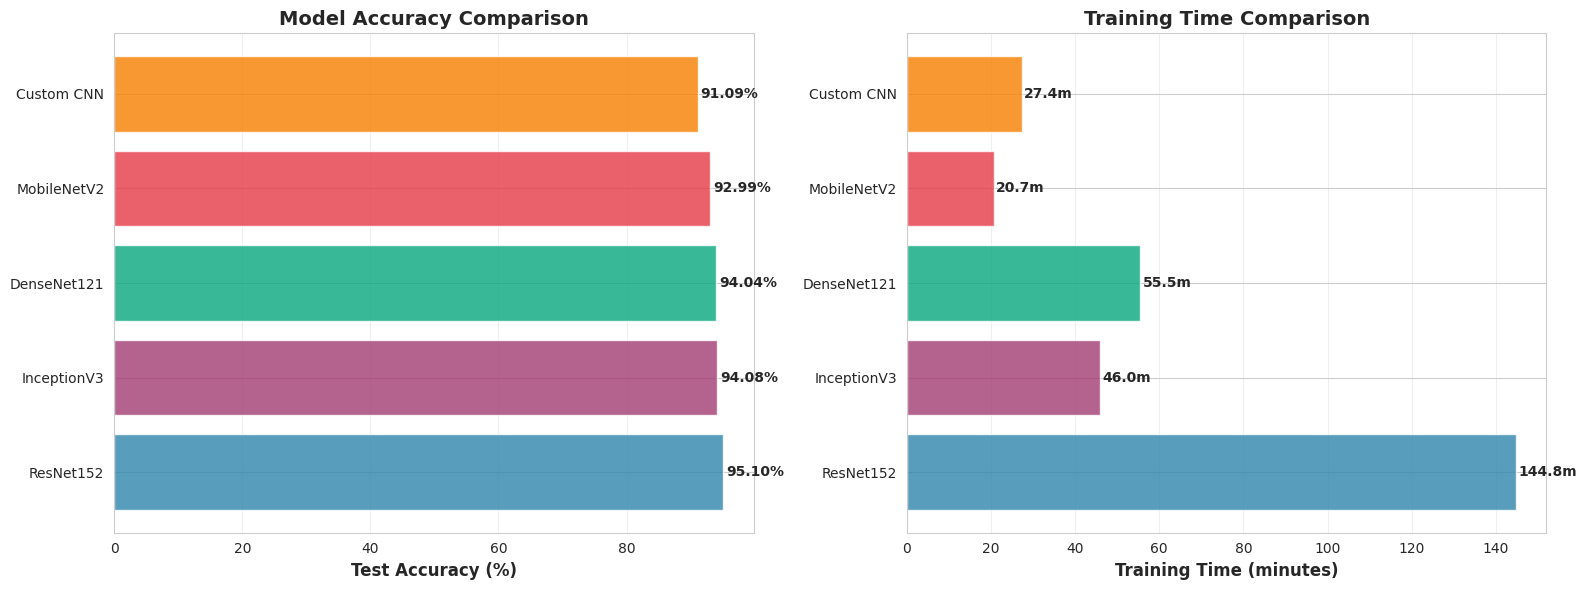

In [27]:
results_summary = {
    'Model': ['Custom CNN', 'ResNet152', 'InceptionV3', 'DenseNet121', 'MobileNetV2'],
    'Test Accuracy (%)': [
        acc_custom * 100,
        acc_resnet * 100,
        acc_inception * 100,
        acc_densenet * 100,
        acc_mobilenet * 100
    ],
    'Training Time (min)': [
        time_custom / 60,
        time_resnet / 60,
        time_inception / 60,
        time_densenet / 60,
        time_mobilenet / 60
    ]
}

results_df = pd.DataFrame(results_summary)
results_df = results_df.sort_values('Test Accuracy (%)', ascending=False)

print("\n" + "="*70)
print("ALL MODELS TRAINED - QUICK COMPARISON")
print("="*70)
print(results_df.to_string(index=False))
print("="*70)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

colors = ['#2E86AB', '#A23B72', '#06A77D', '#E63946', '#F77F00']
ax1.barh(results_df['Model'], results_df['Test Accuracy (%)'], color=colors, alpha=0.8)
ax1.set_xlabel('Test Accuracy (%)', fontsize=12, fontweight='bold')
ax1.set_title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)
for i, v in enumerate(results_df['Test Accuracy (%)']):
    ax1.text(v + 0.5, i, f'{v:.2f}%', va='center', fontweight='bold')

ax2.barh(results_df['Model'], results_df['Training Time (min)'], color=colors, alpha=0.8)
ax2.set_xlabel('Training Time (minutes)', fontsize=12, fontweight='bold')
ax2.set_title('Training Time Comparison', fontsize=14, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)
for i, v in enumerate(results_df['Training Time (min)']):
    ax2.text(v + 0.5, i, f'{v:.1f}m', va='center', fontweight='bold')

plt.tight_layout()
plt.show()